# 120 years of Olympic history: athletes and results

### [BI](https://bioinf.me/) statisctics course Project 1 
> *by* Nikita Vaulin, Skoltech <br />
> Nikita.Vaulin@skoltech.ru

The dataset is adapted by course instructor from [kaggle](https://www.kaggle.com/datasets/heesoo37/120-years-of-olympic-history-athletes-and-results).

<div>
<img src="pictures/olympics.jpg" width="500">
</div>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from statsmodels.stats.multitest import multipletests

> Also Jupyter Notebook like to sens us so many warnings such as FutureWarning and so on. Let's make our output more pretty:

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Reading the data

> We will define here special function which uploads all the files from some with a given extension to a combined pandas dataframe 

In [3]:
sep_readers = {
    ".csv": pd.read_csv,
    ".tsv": pd.read_table,
    ".hdf": pd.read_hdf,
    ".h5": pd.read_hdf,
    ".html": pd.read_html,
    ".htm": pd.read_html,
    ".xml": pd.read_xml,
    ".json": pd.read_json,
    ".xls": pd.read_excel,
    ".xlsx": pd.read_excel,
    ".xltx": pd.read_excel,
    ".ods": pd.read_excel
}


def read_one_table(folder, filename, extension):
    """
    Extra function to read one specific file with function suitable for a given file extension
    """
    file = os.path.join(folder, filename)
    return sep_readers[extension](file)


def file_reader(folder: str = 'athlete_events', ext: str = '.csv') -> pd.DataFrame:
    """
    This function uploads from disk a dataset divided into several files as a single pandas data frame.
    
    Several input files should contain same columns! The number of rows doesn't matter, the function provides 
    row-wise concatenation of input files.
    
    Parameters:
        folder (str): name of a folder with input datasets to read
        ext (str): input files extension
        
    Output:
        Pandas Data.Frame combined from input files row-by-row
    """
    if not ext.startswith('.'):
        ext = f'.{ext}'
    files = [read_one_table(folder, f, ext.lower()) for f in os.listdir(folder) if f.endswith(ext)]
    return pd.concat(files)

> So let's load our data. We don't need any parameters here due to their default values definition

In [4]:
df = file_reader(os.path.join('..', 'data', 'athlete_events'), '.csv')

> Now let's proceed some initial EDA to check weather it everething alright with our data:

In [5]:
df.head(3)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992.0,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012.0,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920.0,Summer,Antwerpen,Football,Football Men's Football,NaN


> Let's highlight here the numerical and categorical features. 
>
> Regarding the Year, this is neither a numerical nor a qualitative variable. Let's consider it a separate type - Time Series.

In [6]:
num_features = ['Age', 'Height', 'Weight']
cat_features = ['Name', 'Sex', 'Team', 'NOC', 'Games', 'Season', 'City', 'Sport', 'Event', 'Medal']

In [7]:
print(f'Here we have {len(df)} entries total in our dataframe\n')
print(f'Some summary about the data:\n')
print(df.info())

Here we have 271115 entries total in our dataframe

Some summary about the data:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271115 entries, 0 to 22390
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271115 non-null  int64  
 1   Name    271114 non-null  object 
 2   Sex     271113 non-null  object 
 3   Age     261639 non-null  float64
 4   Height  210943 non-null  float64
 5   Weight  208239 non-null  float64
 6   Team    271112 non-null  object 
 7   NOC     271111 non-null  object 
 8   Games   271110 non-null  object 
 9   Year    271108 non-null  float64
 10  Season  271108 non-null  object 
 11  City    271108 non-null  object 
 12  Sport   271108 non-null  object 
 13  Event   271107 non-null  object 
 14  Medal   39782 non-null   object 
dtypes: float64(4), int64(1), object(10)
memory usage: 33.1+ MB
None


> This result also could be obtained with `df.isna().sum()` or `df.isnull().sum()` functions

According to the table all the columns expected to be numeric are actually numeric, so i don't see any numbers written as strings

### Finding rubbish in data

> We will deal with missing values later, here about the rabbish

In [8]:
for f in ['Sex', 'Season', 'Medal', 'Games', 'City', 'Sport']:
    print(f'Unique {f} values: {df[f].unique()}')

Unique Sex values: ['M' 'F' 'G' nan]
Unique Season values: ['Summer' 'Winter' nan]
Unique Medal values: [nan 'Gold' 'Bronze' 'Silver']
Unique Games values: ['1992 Summer' '2012 Summer' '1920 Summer' '1900 Summer' '1988 Winter'
 '1992 Winter' '1994 Winter' '1932 Summer' '2002 Winter' '1952 Summer'
 '1980 Winter' '2000 Summer' '1996 Summer' '1912 Summer' '1924 Summer'
 '2014 Winter' '1948 Summer' '1998 Winter' '2006 Winter' '2008 Summer'
 '2016 Summer' '2004 Summer' '1960 Winter' '1964 Winter' '1984 Winter'
 '1984 Summer' '1968 Summer' '1972 Summer' '1988 Summer' '1936 Summer'
 '1952 Winter' '1956 Winter' '1956 Summer' '1960 Summer' '1928 Summer'
 '1976 Summer' '1980 Summer' '1964 Summer' '2010 Winter' '1968 Winter'
 '1906 Summer' '1972 Winter' '1976 Winter' '1924 Winter' '1904 Summer'
 '1928 Winter' '1908 Summer' '1948 Winter' '1932 Winter' '1936 Winter'
 '1896 Summer' '2000 Su' '2004 Summe' nan]
Unique City values: ['Barcelona' 'London' 'Antwerpen' 'Paris' 'Calgary' 'Albertville'
 'Lil

> I see some rubbish here:

- 'G' in Sex
- '2000 Su' and '2004 Summe' in Games
- 'Moskva' in City
- 'Footba' in Sport

> For the Age:

In [9]:
print(sorted(df.Age.dropna().unique()))
mav = df.Age.dropna().sort_values().value_counts().tail(1)
print(f'\nThe most Age value is {mav.index.values.astype(int)} and it appears {mav.values} times')

[10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 80.0, 81.0, 84.0, 88.0, 96.0, 97.0, 240.0]

The most Age value is [240] and it appears [1] times


> This is an obvious outlier - the age is 240 years.
> The same outliers are observable for Height and Weight:

In [10]:
mhv = df.Height.dropna().sort_values().value_counts().tail(1)
lwv = df.Weight.dropna().sort_values().value_counts().tail(1)
print(f'\nThe most Height value is {mhv.index.values.astype(int)} and it appears {mhv.values} times')
print(f'\nThe least Weight value is {lwv.index.values.astype(int)} and it appears {lwv.values} times')


The most Height value is [340] and it appears [1] times

The least Weight value is [7] and it appears [1] times


The NOC county 3-letter codes we will check with 'noc_regions.csv' from the [kaggle](https://www.kaggle.com/datasets/heesoo37/120-years-of-olympic-history-athletes-and-results). I will print Teams as well in order to understad what the country is behind the NOC code.

In [11]:
noc_regions = pd.read_csv(os.path.join('..', 'data', 'noc_regions.csv'))
for region in df['NOC'].unique():
    if region not in noc_regions['NOC'].to_list():
        print(region)
        print(df[df['NOC'] == region].Team.unique())

SGP
['Singapore' 'June Climene' 'Rika II' 'Singapore-2' 'Singapore-1']
nan
[]
JP
['Japan']


> By the way, such a method of finding strange values, which I show here, is the only possible one when working with a unique dataset. If this were a real task, i would have to sit and check every person and every team on the Internet. But we know that there is an ideal dataset on the Internet. We will not engage in stupidity, we will compare everything else with it, and at the same time we will double-check ourselves.

In [12]:
true_df = pd.read_csv(os.path.join('..', 'data', 'athlete_events_ideal.csv'))
for feature in df.columns:
    print(feature, set(df[feature].unique()) - set(true_df[feature].unique()))

ID set()
Name {nan, 'Pietro Spec'}
Sex {nan, 'G'}
Age {nan, 240.0}
Height {nan, 340.0}
Weight {nan, 7.0}
Team {nan}
NOC {nan, 'JP'}
Games {nan, '2004 Summe', '2000 Su'}
Year {nan}
Season {nan}
City {nan}
Sport {nan, 'Footba'}
Event {nan, 'Gymnastics M'}
Medal set()


> Most of theese mismatches we found on our own. Let's check what are the 'Pietro Spec' in Names and 'Gymnastics M' in Events

<sub>The Moskva  is not a rubbish...</sub>

In [13]:
df[df.Name == 'Pietro Spec']

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
22409,113716,Pietro Spec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I see that we will say goodbye to Mr. Pietro Speс after clearing the missing values.

In [14]:
df[df.Event == 'Gymnastics M']

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
22601,57367,Velik Nikolov Kapsazov,M,25.0,167.0,67.0,Bulgaria,BUL,1960 Summer,1960.0,Summer,Roma,Gymnastics,Gymnastics M,NaN


In [15]:
print(true_df.query('ID == 57367 and City == "Roma"').Event)
print(df.query('ID == 57367 and City == "Roma"').Event)

113240    Gymnastics Men's Individual All-Around
113241          Gymnastics Men's Team All-Around
113242           Gymnastics Men's Floor Exercise
113243              Gymnastics Men's Horse Vault
113244            Gymnastics Men's Parallel Bars
113245           Gymnastics Men's Horizontal Bar
113246                    Gymnastics Men's Rings
113247          Gymnastics Men's Pommelled Horse
Name: Event, dtype: object
22599    Gymnastics Men's Individual All-Around
22600          Gymnastics Men's Team All-Around
22601                              Gymnastics M
0                  Gymnastics Men's Horse Vault
1                Gymnastics Men's Parallel Bars
2               Gymnastics Men's Horizontal Bar
3                        Gymnastics Men's Rings
4              Gymnastics Men's Pommelled Horse
Name: Event, dtype: object


Now we see 'Gymnastics Men's Floor Exercise' was lost

I also see some entry that was spoiled totally but presents in ideal df.

In [16]:
one_id = int(true_df[true_df.Name == 'Thomas Hendrikus Maria "Thom" van Dijck'].ID.values)
df[df.ID == one_id]

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
22463,124516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


###### Let's fix all of this stuff

> For sex 'G' obviously they are male:

In [17]:
df[df.Sex == 'G']

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
42,79609,Pavel Mike,G,22.0,182.0,79.0,Czechoslovakia,TCH,1972 Summer,1972.0,Summer,Munich,Handball,Handball Men's Handball,Silver
74,79630,Anatoly Mikhaylin,G,37.0,NaN,NaN,Russia,RUS,1996 Summer,1996.0,Summer,Atlanta,Sailing,Sailing Mixed Two Person Keelboat,NaN


In [18]:
df.Sex.replace('G', 'M', inplace=True)
df.Sport.replace('Footba', 'Football', inplace=True)
df.Games.replace('2000 Su', '2000 Summer', inplace=True)
df.Games.replace('2004 Summe', '2004 Summer', inplace=True)
df.NOC.replace('JP', 'JPN', inplace=True)
df.Event.replace("Gymnastics M", "Gymnastics Men's Floor Exercise", inplace=True)

In [19]:
df = df[df.Age != 240]
df = df[df.Height != 340]
df = df[df.Weight != 7]

In any case, such a replacement would not be possible without an ideal dataset. In real life, you may have to restore corrupted values using the Internet or even drop them.

### Dealing with missing values

>We see there some missing values in some features. Let's make that numbers more illustratory:

<Figure size 720x432 with 0 Axes>

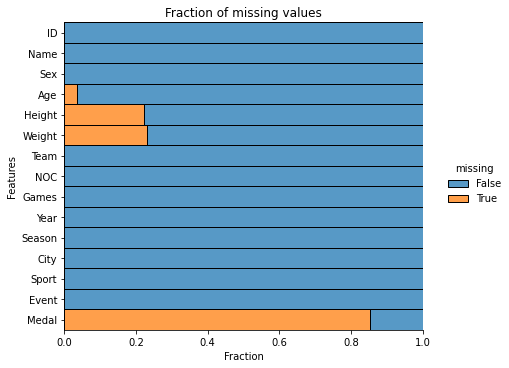

In [20]:
plt.figure(figsize=(10, 6))
sns.displot(
    data=df.isna().melt(value_name="missing"),
    y="variable",
    hue="missing",
    multiple="fill",
    aspect=1.25
)
plt.xlabel("Fraction")
plt.ylabel("Features")
plt.title("Fraction of missing values")
plt.savefig("pictures/Missing_values_in_raw_dataset_count.png", dpi=100)
plt.show()

> Here we see how many missing values are there. But how are they distributed? Let's check weather is there some correlation between value's missingnesses

<Figure size 432x288 with 0 Axes>

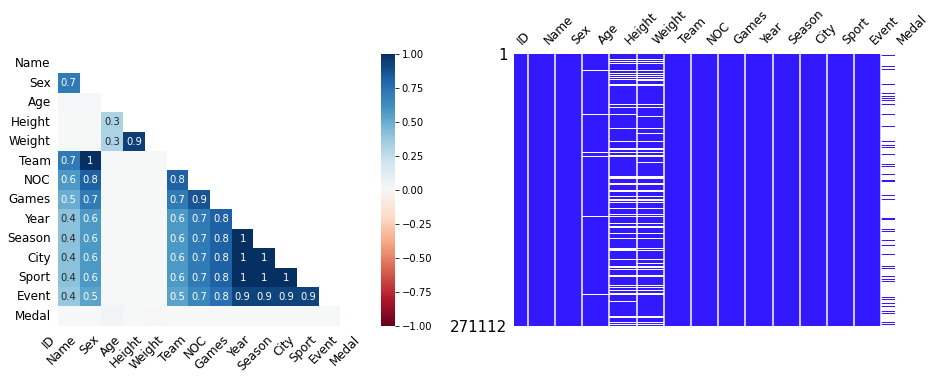

In [21]:
plt.figure()
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15, 5))
msno.heatmap(df, ax=axes[0], figsize=(8, 5), fontsize=12)
msno.matrix(df, ax=axes[1], sparkline=False, figsize=(6, 5), fontsize=12, color=(0.2, 0.10, 1.0));
plt.savefig("pictures/Missing_values_in_raw_dataset_correlation.png", dpi=100)
plt.show()

> We have some features with 1 - 2 missing values, some with 7 - 8 and 4 features with much more missing values. Firstly, let's deal with first and seconds ones.

In [22]:
df[df.Event.isna()]

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
22835,12005,Andrea Melissa Blackett,F,24.0,167.0,59.0,Barbados,BAR,2000 Summer,NaN,NaN,NaN,NaN,NaN,NaN
22586,23433,Hadj Moussa Coulibaly,M,23.0,NaN,NaN,Mali,MLI,2004 Summer,NaN,NaN,NaN,NaN,NaN,NaN
22557,34727,Carlotta Ferlito,F,17.0,160.0,50.0,Italy,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22659,45919,Yuka Harada,F,28.0,170.0,60.0,Japan,JPN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22781,91137,Georgios Pantos,M,NaN,NaN,NaN,Athens-2,GRE,1906 Summer,1906.0,Summer,Athina,Football,NaN,NaN
22409,113716,Pietro Spec,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22463,124516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


> Here we see some obviously bad entries. There is no sence to try to fix it somehow, it is better just to drop that 8 rows on a 271115-length scale. Moreover, such features as Event, Sport, City and Season have strongest correlation in values lost so we will fix all of them at once. After that we will think about other missing values.

In [23]:
df.dropna(axis=0, subset=["Event"], inplace = True)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271105 entries, 0 to 22390
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271105 non-null  int64  
 1   Name    271105 non-null  object 
 2   Sex     271105 non-null  object 
 3   Age     261632 non-null  float64
 4   Height  210938 non-null  float64
 5   Weight  208234 non-null  float64
 6   Team    271105 non-null  object 
 7   NOC     271105 non-null  object 
 8   Games   271105 non-null  object 
 9   Year    271105 non-null  float64
 10  Season  271105 non-null  object 
 11  City    271105 non-null  object 
 12  Sport   271105 non-null  object 
 13  Event   271105 non-null  object 
 14  Medal   39782 non-null   object 
dtypes: float64(4), int64(1), object(10)
memory usage: 33.1+ MB
None


> Medal feature looks really intriguing with so many missing values!

In [24]:
print(df.Medal.unique())

[nan 'Gold' 'Bronze' 'Silver']


> O-o-o! For now it's clear. 'NaN' here means no medal. Thats easy to fix.
>
> By the way, if we had machine learning here, we would immediately turn it into a numerical categorical feature from 0 to 3

In [25]:
df.Medal.fillna("No medal", inplace = True)
print(df.Medal.unique())

['No medal' 'Gold' 'Bronze' 'Silver']


> Let's take a clother look at Age, Height and Weight values:

> For missing values in Age:

In [26]:
print(f'The {round(len(df[df.Age.isna()])*100/len(df),1)}% of enties are contain missing Age')

The 3.5% of enties are contain missing Age


Not great, not terrible, let's remove them.

In [27]:
df.dropna(subset=["Age"], axis = 0, inplace = True)

> With height and weight everything is a little more complicated. These variables are quite important, and the number of missing values in them is too large. Let's make two new dataframes using two different techniques, and then we'll see how it goes better. In one data frame we will completely remove all these missing values, and in the other, we will somehow replace them with.

In [28]:
print(f'The {round(len(df[df.Height.isna()])*100/len(df),1)}% of enties are contain missing Height')

The 19.7% of enties are contain missing Height


> How to replace Height and Weight? Maybe we want to put here, for example, the average values. But this is impossible due to many other features in the dataset. Okay, you can say calculate the average for certain groups and substitute it depending on the group. Also incorrect - our data contains a time series. So, for time series, there are 3 main ways to fill in missing values: forward and backward filling and interpolation. In order to take into account all these moments, we will do, for example, backfilling with division into groups. As grouping variables, we will take age, gender, country and year - they should have the greatest influence on Height and Weight. Ideally, of course, we would break the age into separate intervals, but we have a lot of data and in this case we will not do feature generation and complicate things too much.

In [29]:
print(f'Mean Height is {int(df.Height.mean())}')
print(f'Mean Weight is {int(df.Weight.mean())}')
df_gimp = df.copy()

df_drop = df.dropna(subset=['Height', 'Weight'])
df_gimp.Height = df.groupby(['Age', 'Sex'])['Height'].ffill().bfill()
df_gimp.Weight = df.groupby(['Age', 'Sex'])['Weight'].ffill().bfill()

print(f'df_gimp shape is {df_gimp.shape}')
print(f'df_drop shape is {df_drop.shape}')

Mean Height is 175
Mean Weight is 70
df_gimp shape is (261632, 15)
df_drop shape is (206158, 15)


> Firts of all, let's try to work with imputed-one dataframe and the cleaned one will be reserved.

### EDA

#### 3. What is the age of most young sportsmens of both sexes at Olympics 1992?

In [30]:
df_gimp[df_gimp.Year == 1992].groupby("Sex")["Age"].min()

Sex
F    12.0
M    11.0
Name: Age, dtype: float64

#### 4. What is the mean and standart deviation of the Height for both sexes

In [31]:
df_gimp.groupby("Sex")["Height"].describe()[["mean", "std"]]
# or
df_gimp.groupby("Sex").agg({'Height':["mean","std"]})

Height          
           mean       std
Sex                      
F    167.942479  8.794632
M    179.066542  9.322936

#### 5. What is the mean and standart deviation of the Height for woman in tennis at Olympics 2000?

In [32]:
df_gimp.query('Year == 2000 and Sex == "F" and Sport == "Tennis"').agg({'Height': ["mean", "std"]})


,Height
mean,171.801587
std,6.433686


#### 6. In what sport did the heaviest sportsmen participated at Olympics 2006?

In [33]:
    max_weight = df_gimp.query('Year == 2006').Weight.max()
    df_gimp.query('Year == 2006')[df_gimp.query('Year == 2006').Weight == max_weight].Sport

8102    Skeleton
Name: Sport, dtype: object

#### 7. How many gold medals were won by women from 1980 to 2010?

In [34]:
df_gimp.query('1980 <= Year <= 2010 and Sex == "F" and Medal == "Gold"').shape[0]

2249

#### 8. How many times has John Aalberg competed in the Olympics in different years?

In [35]:
JA_all = df_gimp.query('Name == "John Aalberg"').shape[0]
JA_games = df_gimp.query('Name == "John Aalberg"').Games.nunique()
JA_years = df_gimp.query('Name == "John Aalberg"').Year.nunique()
print(f'John Aalberg participated in {JA_all} competitions totally in {JA_games} games in {JA_years} years')

John Aalberg participated in 8 competitions totally in 2 games in 2 years


#### 9. Determine the least and most represented (by number of participants) age groups of athletes at the 2008 Olympics

In [36]:
df_gimp2008 = df_gimp.query('Year == 2008')
df_gimp2008["Age_group"] = pd.cut(x=df_gimp2008['Age'], bins=[15, 25, 35, 45, 55], right=False)
groups_count = df_gimp2008.groupby('Age_group').Name.count()
print(f'Our age groups are: \n{groups_count}')
print(f'The least group is {groups_count.nlargest(4).index[3]} and the most is {groups_count.nlargest(4).index[0]}')

Our age groups are: 
Age_group
[15, 25)    6294
[25, 35)    6367
[35, 45)     790
[45, 55)     116
Name: Name, dtype: int64
The least group is [45, 55) and the most is [25, 35)


#### 10. How much has the number of sports changed in the 2002 Olympics compared to the 1994 Olympics?

In [37]:
def n_sports(df, year):
    return df[df.Year == year].Sport.nunique()


print(f'There are {len(set(df[df.Year == 2002].Sport) - set(df[df.Year == 1994].Sport))} sports changed')

# I suppose the sets difference is the most right way here becouse .nunique() would not take into account cases when,
# for example, no new sports appeared but there were some changes

There are 3 sports changed


#### 11. Output for the winter and summer Olympics separately the top 3 countries for each type of medals

In [38]:
counts = df_gimp[['Medal', 'Season', 'NOC']].query('Medal != "No medal"').groupby(['Season', "Medal"]).apply(
    lambda x: x.value_counts().head(3))
counts = counts.reset_index(level=[2, 3])[[0]].rename(columns={0: "Medals"})
counts


Medals
Season Medal  NOC        
Summer Bronze USA    1185
              GER     644
              URS     596
       Gold   USA    2461
              URS     832
              GBR     616
       Silver USA    1311
              GBR     674
              URS     635
Winter Bronze FIN     215
              SWE     177
              USA     161
       Gold   CAN     305
              URS     250
              USA     166
       Silver USA     308
              CAN     199
              NOR     165

#### 12. Create a new variable Height_z_scores and store the values of the Height variable into it after it has been standardized

In [39]:
def standardize(values):
    return (values - values.mean()) / values.std()


df_gimp['Height_z_scores'] = standardize(df_gimp.Height)

#### 13. Create a new variable Height_min_max_scaled and store the values of the Height variable into it after it has been min-max normalized

Here I could define another one my own function, but since it is an additional task I also add some to solution (the thing I also wanted do in a previous task):

In [40]:
from sklearn.preprocessing import MinMaxScaler

min_max = MinMaxScaler()
min_max.fit(df_gimp[['Height']])
df_gimp['Height_min_max_scaled'] = min_max.transform(df_gimp[['Height']])

#### 14. Compare the height, weight and age of men and women who competed in the Winter Olympics

In [41]:
from scipy import stats


def honest_t_test(x, y):
    for z in [x, y]:
        if stats.shapiro(z).pvalue < 0.05:
            raise Exception('The data is not normally distributed!')
    if stats.levene(x, y).pvalue < 0.05:
        raise Exception('Samples are not homoscedantic!')
    return stats.ttest_ind(x, y)

In [42]:
test_1 = stats.ttest_ind(df_gimp.query('Season == "Winter" and Sex == "M"').Height,
                         df_gimp.query('Season == "Winter" and Sex == "F"').Height)
test_2 = stats.ttest_ind(df_gimp.query('Season == "Winter" and Sex == "M"').Weight,
                         df_gimp.query('Season == "Winter" and Sex == "F"').Weight)
test_3 = stats.ttest_ind(df_gimp.query('Season == "Winter" and Sex == "M"').Age,
                         df_gimp.query('Season == "Winter" and Sex == "F"').Age)

tests = pd.DataFrame([['Height', test_1.pvalue], ['Weight', test_2.pvalue], ['Age', test_3.pvalue]],
                     columns=['Feature', 'p_value'])
tests['p_value_adj'] = [float(f'{x :.2g}') for x in multipletests(tests.p_value.values, alpha=0.05, method='hs')[1]]
tests['p_value'] = [float(f'{x :.2g}') for x in tests['p_value']]
tests['Significant_differences'] = tests['p_value_adj'] < 0.05
tests = tests.set_index('Feature')

Here we tested 3 hypotises, conducted p-valiue adjustments, rounded results and labbeled whether are there significant differences between males and females . Now we can print it for publishind, for example, as a markdown table  

In [43]:
print(tests.to_markdown()) 

| Feature   |   p_value |   p_value_adj | Significant_differences   |
|:----------|----------:|--------------:|:--------------------------|
| Height    |  0        |      0        | True                      |
| Weight    |  0        |      0        | True                      |
| Age       |  1.2e-223 |      1.2e-223 | True                      |


##### Do height, weight and age significantly differ for men and women who competed in the Winter Olympics?

| Feature   |   p_value |   p_value_adj | Significant_deffirinces   |
|:----------|----------:|--------------:|:--------------------------|
| Height    |  0        |      0        | True                      |
| Weight    |  0        |      0        | True                      |
| Age       |  1.2e-223 |      1.2e-223 | True                      |

#### 15. Are the Team and the Medal related?

Lets build a contingency table`

In [44]:
ct = pd.crosstab(df_gimp.Team, df_gimp.Medal, margins=True)
ct.iloc[-5:]

Medal,Bronze,Gold,No medal,Silver,All
Team,,,,,
Zefyros,0,0,2,0,2
Zimbabwe,1,17,284,4,306
Zut,0,0,0,3,3
rn-2,0,0,5,0,5
All,13006,13224,222582,12820,261632


<AxesSubplot: xlabel='Medal', ylabel='Team'>

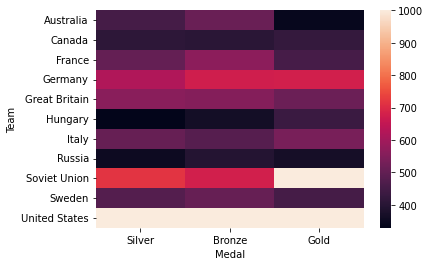

In [45]:
sns.heatmap(ct.iloc[0:len(ct) - 2].query('Bronze + Silver + Gold > 1000')[['Silver', 'Bronze', 'Gold']], vmax=1000)

Here we see some teams have more medals than the others, but we need somehow to prove it. Additionaly, of couse, we need take into account number of games a team played. Thus, lets normalize each team's values.

In [46]:
ct_normalized = ct.apply(lambda x: x / ct.All, axis=0)
ct_normalized.iloc[-5:]

Medal,Bronze,Gold,No medal,Silver,All
Team,,,,,
Zefyros,0.000000,0.000000,1.000000,0.000000,1.0
Zimbabwe,0.003268,0.055556,0.928105,0.013072,1.0
Zut,0.000000,0.000000,0.000000,1.000000,1.0
rn-2,0.000000,0.000000,1.000000,0.000000,1.0
All,0.049711,0.050544,0.850745,0.049000,1.0


<AxesSubplot: xlabel='Team'>

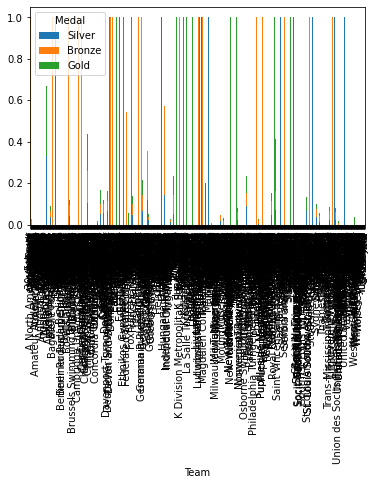

In [47]:
ct_normalized[['Silver','Bronze', 'Gold']].plot.bar(stacked=True)

Once again, we see medals not uniformely distributed. The teams are not clearly seen, yeah, this plot is not for publishing.  

However, we need to do a statistical analysis of this. We use Pearson's chi-square test for cross tables. It could even be calculated manually, but I know a package that allows you to build contingency tables immediately with the calculation of these statistic. As before, we will normalize data by rows (only in this case, the normalization is not in fractions, but in percentages).

In [48]:
import researchpy as rp

ct_rp, ct_chi2_test = rp.crosstab(df_gimp.Team, df_gimp.Medal, prop='row', test='chi-square')
ct_rp.head()

Medal                            
Medal                  Bronze Gold No medal Silver    All
Team                                                     
30. Februar              0.00  0.0   100.00    0.0  100.0
A North American Team  100.00  0.0     0.00    0.0  100.0
Acipactli                0.00  0.0   100.00    0.0  100.0
Acturus                  0.00  0.0   100.00    0.0  100.0
Afghanistan              2.56  0.0    97.44    0.0  100.0

In [49]:
ct_chi2_test

,Chi-square test,results
0,Pearson Chi-square ( 3324.0) =,41021.6856
1,p-value =,0.0000
2,Cramer's V =,0.2286


In [50]:
if ct_chi2_test.results[1] < 0.05:
    dependence = 'some'
else:
    dependence = 'no'

print(
    f'The pearson chi-square statistics is {round(ct_chi2_test.results[0], 2)} with p-value {ct_chi2_test.results[1]}')
print(f'That means there are {dependence} statistical dependence between Teams and Medals')

The pearson chi-square statistics is 41021.69 with p-value 0.0
That means there are some statistical dependence between Teams and Medals


### 16. Additional hypotheses

#### Athletes height through the years

In [51]:
pearr = stats.pearsonr(df_gimp.Height, df_gimp.Year)

if pearr.pvalue < 0.05:
    dependence = 'some'
else:
    dependence = 'no'

if pearr.statistic < 0:
    changes = 'decrease'
else:
    changes = 'increase'

if abs(pearr.statistic) > 0.6:
    significance = 'significantly'
else:
    significance = 'slightly'

print(f'The pearson r coefficient is {round(pearr.statistic, 3)} with p-value {pearr.pvalue:.2g}')
print(f'That means there are {dependence} statistical dependence between athletes Height and Year')
print(f'Moeover, we can say that athletes Height {significance} {changes} through the years')

The pearson r coefficient is -0.061 with p-value 4.6e-212
That means there are some statistical dependence between athletes Height and Year
Moeover, we can say that athletes Height slightly decrease through the years


#### Does the first letter in the name matter? 

The pearson chi-square statistics is 390.01 with p-value 0.0
That means there are some statistical dependence between first letter in the name and medals


Text(0.5, 15.0, 'Medal')

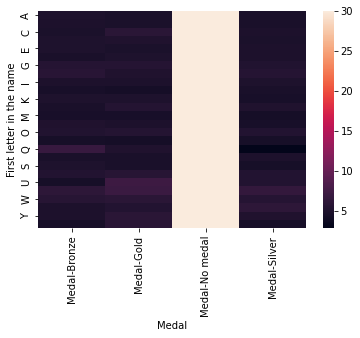

In [52]:
df_gimp['First_letter'] = df_gimp.Name.apply(lambda x: x[0].upper())
ct_rp, ct_chi2_test = rp.crosstab(df_gimp.First_letter, df_gimp.Medal, prop='row', test='chi-square')

if ct_chi2_test.results[1] < 0.05:
    dependence = 'some'
else:
    dependence = 'no'

print(
    f'The pearson chi-square statistics is {round(ct_chi2_test.results[0], 2)} with p-value {ct_chi2_test.results[1]}')
print(f'That means there are {dependence} statistical dependence between first letter in the name and medals')

sns.heatmap(ct_rp.iloc[1:len(ct_rp) - 1, 0:4], vmax=30);
plt.ylabel("First letter in the name")
plt.xlabel("Medal")

#### Let's take a closer look at what is that - to be a Nikita

The pearson chi-square statistics is 0.23 with p-value 0.9719
That means there are no statistical dependence between Nikitas and medals


Text(33.0, 0.5, 'Is Nikita?')

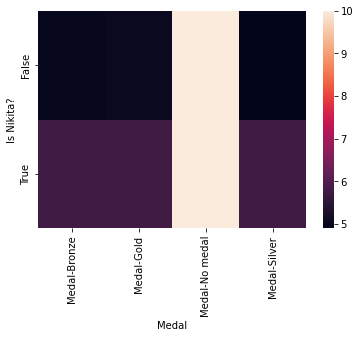

In [53]:
df_gimp['Is_Nikita'] = df_gimp.Name.str.contains('Nikita')

ct_rp, ct_chi2_test = rp.crosstab(df_gimp.Is_Nikita, df_gimp.Medal, prop='row', test='chi-square')

if ct_chi2_test.results[1] < 0.05:
    dependence = 'some'
else:
    dependence = 'no'

print(
    f'The pearson chi-square statistics is {round(ct_chi2_test.results[0], 2)} with p-value {ct_chi2_test.results[1]}')
print(f'That means there are {dependence} statistical dependence between Nikitas and medals')

sns.heatmap(ct_rp.iloc[0:len(ct_rp) - 1, 0:4], vmax=10);
plt.xlabel("Medal")
plt.ylabel("Is Nikita?")

As we can see, the p-value is quite large and there is not much statistical significance, but on the heatmap (despite the fact that the sizes of the groups are highly disproportional) with adjusted brightness, it can be seen that Nikita's medal strip is a little bit brighter. Noone can hide the truth!